<a href="https://colab.research.google.com/github/jenfad/machinelearning_code_along/blob/main/Magic_FCC_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

The data set was generated by a Monte Carlo program, Corsika, described in:
    D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers,
    Forschungszentrum Karlsruhe FZKA 6019 (1998).
http://rexa.info/paper?id=ac6e674e9af20979b23d3ed4521f1570765e8d68
  Dataset here: https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving magic04.data to magic04.data
User uploaded file "magic04.data" with length 1477391 bytes


In [ ]:
#need to add column titles as indicated on website with dataset information
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv("magic04.data", names=cols)

In [ ]:
print(df)

        fLength    fWidth   fSize   fConc  fConc1     fAsym   fM3Long  \
0       28.7967   16.0021  2.6449  0.3918  0.1982   27.7004   22.0110   
1       31.6036   11.7235  2.5185  0.5303  0.3773   26.2722   23.8238   
2      162.0520  136.0310  4.0612  0.0374  0.0187  116.7410  -64.8580   
3       23.8172    9.5728  2.3385  0.6147  0.3922   27.2107   -6.4633   
4       75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277   28.5525   
...         ...       ...     ...     ...     ...       ...       ...   
19015   21.3846   10.9170  2.6161  0.5857  0.3934   15.2618   11.5245   
19016   28.9452    6.7020  2.2672  0.5351  0.2784   37.0816   13.1853   
19017   75.4455   47.5305  3.4483  0.1417  0.0549   -9.3561   41.0562   
19018  120.5135   76.9018  3.9939  0.0944  0.0683    5.8043  -93.5224   
19019  187.1814   53.0014  3.2093  0.2876  0.1539 -167.3125 -168.4558   

       fM3Trans   fAlpha     fDist class  
0       -8.2027  40.0920   81.8828     g  
1       -9.9574   6.3609  205.2610   

In [ ]:
#class has either g or h, which stands for gamma or hadron, bc computer is better at handling numbers as comparison, switching to integer
df['class'] = (df['class']=='g').astype(int)
#so if g it will now be one; if it's not (or h), it will be 0

In [ ]:
df['class'].unique

<bound method Series.unique of 0        1
1        1
2        1
3        1
4        1
        ..
19015    0
19016    0
19017    0
19018    0
19019    0
Name: class, Length: 19020, dtype: int64>

Features are what pass into model to predict attribute, in this case would have 10 features to predict class.  With supervised learning, we already know the output label for the labelled inputs for use to train models.
Unsupervised learning uses unlabelled data to learn about patterns in data.  Reinforcement learning is agent learning in interactive environment based on rewards and penalties.
Supervised learning


*   Qualitative data
>*   nominal data: no order to categories, use one-hot encoding (1 in a position in an array if it has that category) e.g. USA = [1,0,0], India = [0,1,0], Canada = [0,0,1]
>* Ordinal Data: inherent order; give number for each


*   Quantitative: discrete or continuous
*   Can do classification (predict discrete classes, multi class or binary); regression (predict continuous values)
*terms: feature vector, target, feature matrix - x, labels/target vector - y
* compare prediction for a feature vector to the actual valua (y)
* break up to training, validation and testng datasets (60,20,20) or (80,10,10%) depending on how many statistics have
* training dataset into model get prediction, figure out loss (difference with actual labels; L1 Loss = sum(|yreal-ypredicted|), L2 Loss = sum((yreal-ypredicted)^2) - more penalty if off by more) & make adjustments, binary cross-entropy loss - longer equation but loss decreases as performance gets better)
* put validation set through model use as reality check to make sure can handle unseen data; check loss but never put back into model
* can take model with least loss and run test set through to check how generalizable chosen model is and to see final reported performance
* Accuracy: % of predictions correct




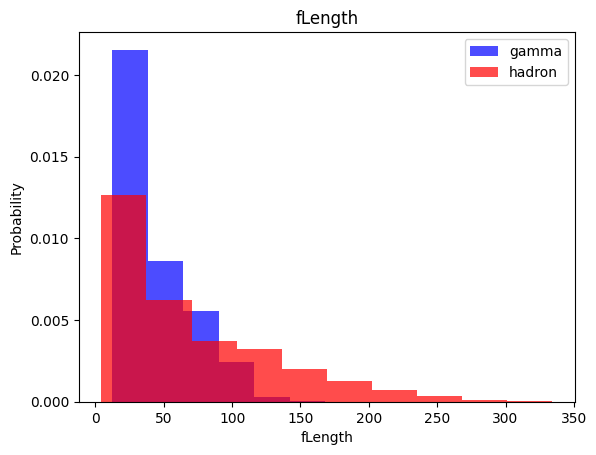

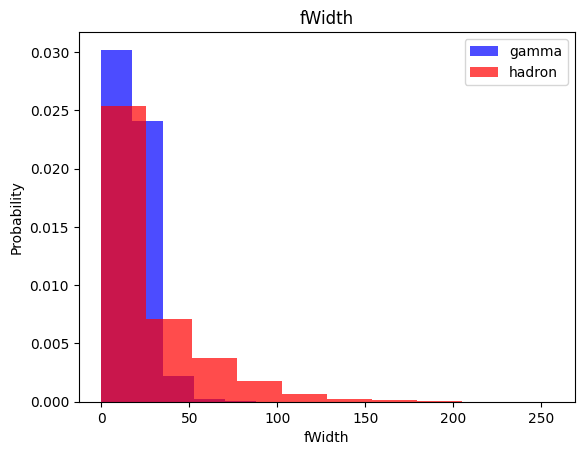

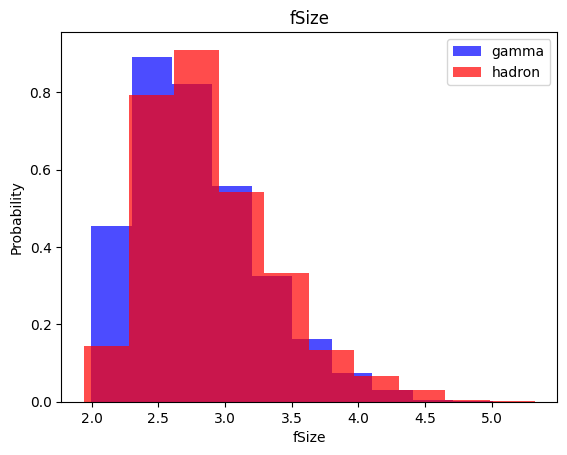

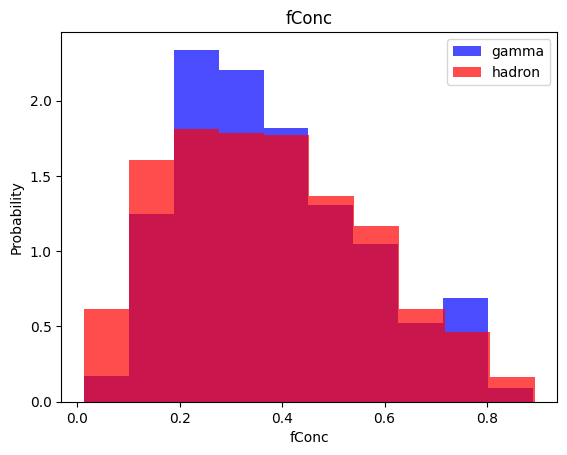

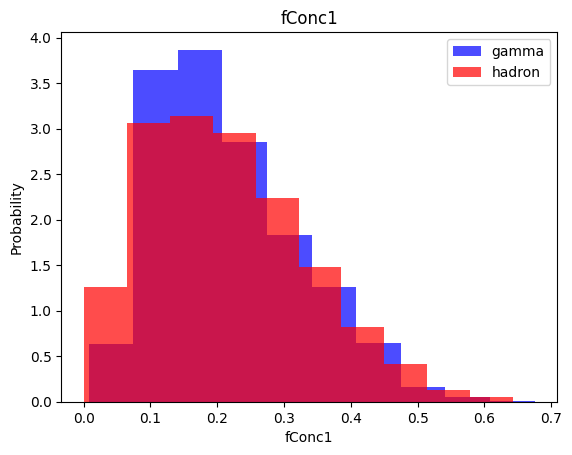

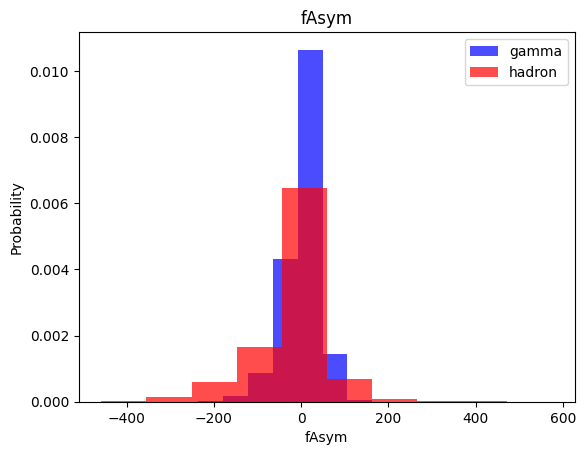

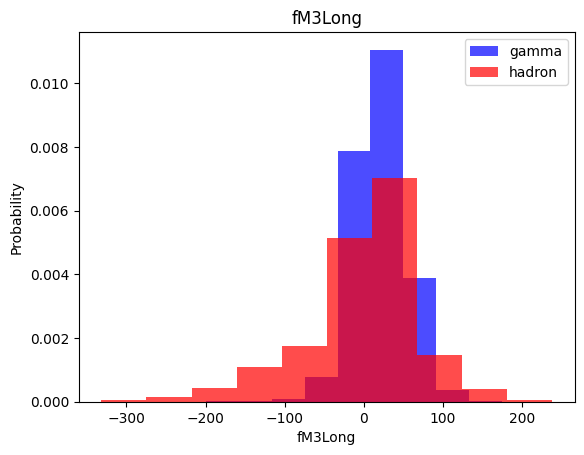

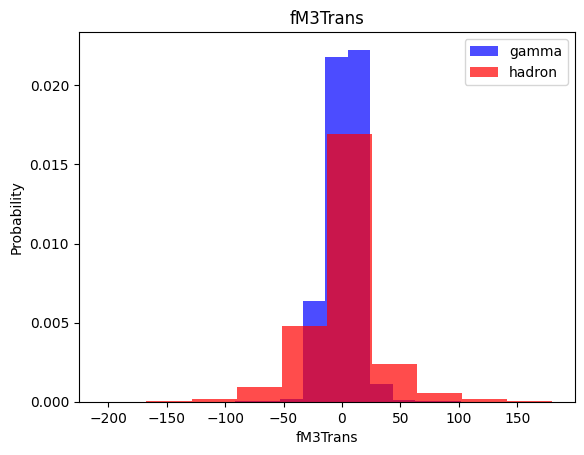

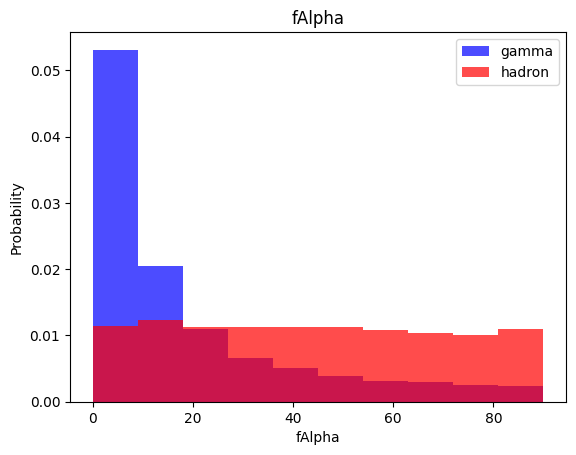

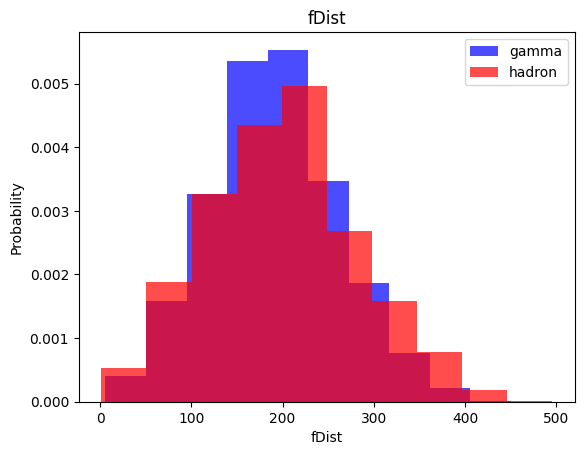

In [ ]:
# for all rows in df where class = 1, get all values for the corresponding label, see if they have anything to do with class; density = true normalizes for gamma and hadron
for label in cols[:-1]:
  plt.hist(df[df["class"]==1][label], color="blue", label="gamma", alpha = 0.7, density=True)
  plt.hist(df[df["class"]==0][label], color="red", label="hadron", alpha=0.7, density=True)
  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

#Train, validation and test datasets

In [ ]:
#60% into train, then from 60-80% (20%) to validation, rest to testing
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [ ]:
print(len(train[train["class"]==1])) #gamma
print(len(train[train["class"]==0])) #hadron

7470
3942


In [ ]:
#over 7,000 gamma but only 4,000 hadron values, so want to oversample hadron so match better

In [ ]:
#some attributes have numbers at a much larger scale than other attributes if see data above, so scale also want to be able to oversample if needed
def scale_dataset(dataframe, oversample=False):
  x = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler = StandardScaler()
  x = scaler.fit_transform(x)

  if oversample:
    ros = RandomOverSampler()
    x, y = ros.fit_resample(x, y)

  #stack arrays side by side, need to reshape y to 2d so can stack with other 2d (x); -1 as first number in reshape means infer the length which ends up being lenght of y
  data = np.hstack((x, np.reshape(y, (-1,1))))
  return data, x, y

In [ ]:
train1, x_train, y_train = scale_dataset(train, oversample=True)

In [ ]:
#now balanced between gamma and hadron labels
print(sum(y_train == 1))
print(sum(y_train == 0))

7358
7358


In [ ]:
#do same for validation and testing datasets but no oversampling since trying to see how model performs
#unlike the video, scaling the same way as training data instead of own way for each set, to avoid bias or skwedness (see https://datascience.stackexchange.com/questions/39932/feature-scaling-both-training-and-test-data for explanation)
valid, x_valid, y_valid = scale_dataset(train, oversample=False)
test, x_test, y_test = scale_dataset(train, oversample=False)

# kNN
k-nearest neighbors - KNN: what's around the same point and assign it label with those around it; different distances, eg given number of kids and income, do they have kids

*   Euclidian distance: straight line distance from point to another; d = squ((x1-x2)^2 + (y1-y2)^2 ...)
*   k is how many closest neighbors we use to predict, 3 or 5 can be good

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1326
           1       0.85      0.85      0.85      2478

    accuracy                           0.81      3804
   macro avg       0.79      0.79      0.79      3804
weighted avg       0.81      0.81      0.81      3804



precision is % of true positives out of what the model labelled as positive (true positive + false positives) \
recall is percent of true positives out of what was actually positive (true posiitive + false negatives)

# Naive Bayes

Naive Bayes:
rule is that probability of Category K given different factors is proportional to the probability of Category K times the multiplication of the probability of each factor given Category K



In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb_model = GaussianNB()
nb_model.fit(x_train, y_train)

GaussianNB()

In [ ]:
y_pred = nb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.41      0.51      1326
           1       0.74      0.90      0.81      2478

    accuracy                           0.73      3804
   macro avg       0.71      0.65      0.66      3804
weighted avg       0.72      0.73      0.71      3804



Naive Bayes, at least for this dataset, got worst scores thatn kNN

#Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lg_model = LogisticRegression()
#L2 is the default penalty, which is a quadratic formula that would penalize outliers; can toggle different parameters and get different results; test on validation data before pushing to prod
lg_model = lg_model.fit(x_train, y_train)

In [ ]:
y_pred = lg_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.71      0.70      1326
           1       0.84      0.82      0.83      2478

    accuracy                           0.78      3804
   macro avg       0.76      0.77      0.76      3804
weighted avg       0.79      0.78      0.78      3804



#Support Vector Machines (SVM)

Another model for classification

In [ ]:
from sklearn.svm import SVC
#SVC is support vector classifier

In [ ]:
svm_model = SVC()
svm_model = svm_model.fit(x_train, y_train)

In [ ]:
y_pred = svm_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1326
           1       0.89      0.89      0.89      2478

    accuracy                           0.85      3804
   macro avg       0.84      0.84      0.84      3804
weighted avg       0.85      0.85      0.85      3804



# Neural Networks

In [ ]:
import tensorflow as tf

In [ ]:
#plotting loss accross different Epochs (training cycles)
def plot_loss(history):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Binary crossentropy')
  ax1.legend()
  ax1.grid(True)


  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  ax2.grid(True)

  plt.show()

In [ ]:
# a lot of ML is changing the parameters in the next couple of lines to see what happens (e.g. nodes, learning rate, epochs etc)
# dropout means choose certain nodes and don't train them to avoid overtraining; include prob of dropping node during training
def train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([tf.keras.layers.Dense(num_nodes, activation='relu', input_shape =(10,)),
                                  tf.keras.layers.Dropout(dropout_prob),
                                  tf.keras.layers.Dense(num_nodes, activation='relu'),
                                  tf.keras.layers.Dropout(dropout_prob),
                                  tf.keras.layers.Dense(1, activation='sigmoid')])
  #after the first layer, don't need to specify the size of the input anymore; above input array with numpy array 1-D shape of (None, 10)
  #sigmoid for last layer so can essentially limit our prediction to 0 or 1 - can round to 0 or 1 and classify that way

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="binary_crossentropy", metrics=['accuracy'])
  #adam optimizer is most often used; default learning rate is 0.001, imcl accuracy metric so can see in plot

  #tensorflow keeps track of history of training which is why we can plot it afterwards
  #for validation split, like our validation data, but tenserflow does it during the training
  #could pass on validation data instead of validation split
  history = nn_model.fit(
      x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose = 0
  )

  return nn_model, history

16 nodes, dropout 0, learning rate 0.01, batch size 32


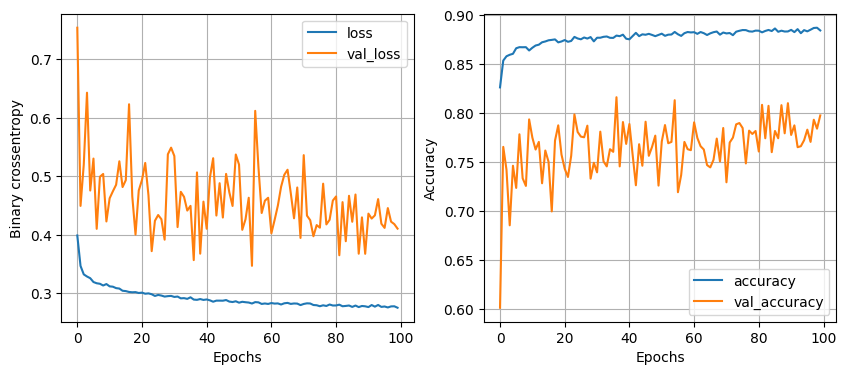

357/357 [==============================] - 1s 2ms/step - loss: 0.2733 - accuracy: 0.8899
16 nodes, dropout 0, learning rate 0.01, batch size 64


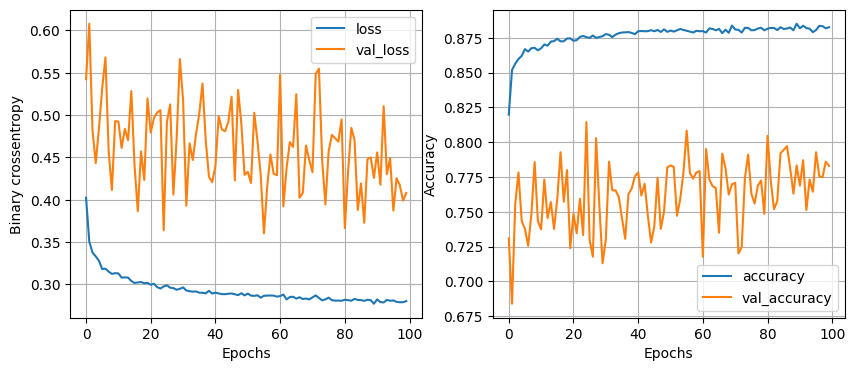

357/357 [==============================] - 1s 1ms/step - loss: 0.2688 - accuracy: 0.8908
16 nodes, dropout 0, learning rate 0.01, batch size 128


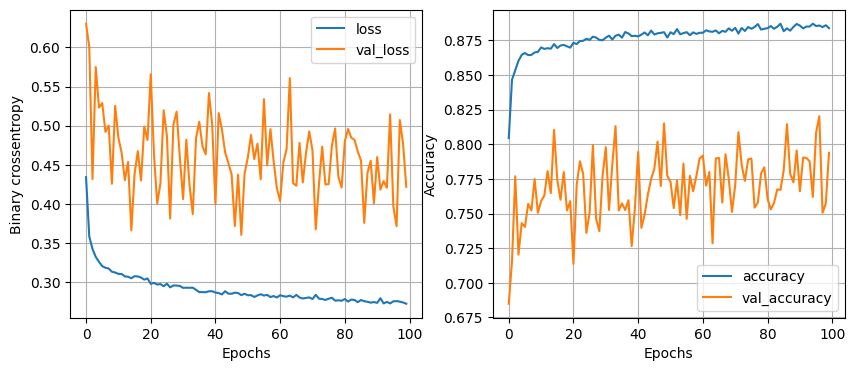

357/357 [==============================] - 1s 2ms/step - loss: 0.2634 - accuracy: 0.8914
16 nodes, dropout 0, learning rate 0.005, batch size 32


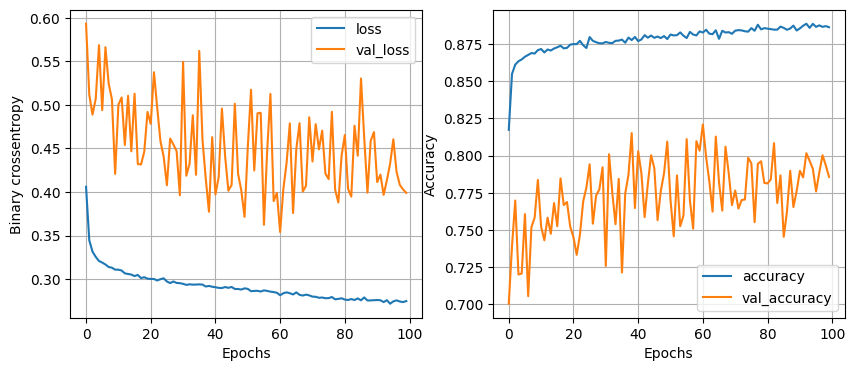

357/357 [==============================] - 1s 2ms/step - loss: 0.2670 - accuracy: 0.8903
16 nodes, dropout 0, learning rate 0.005, batch size 64


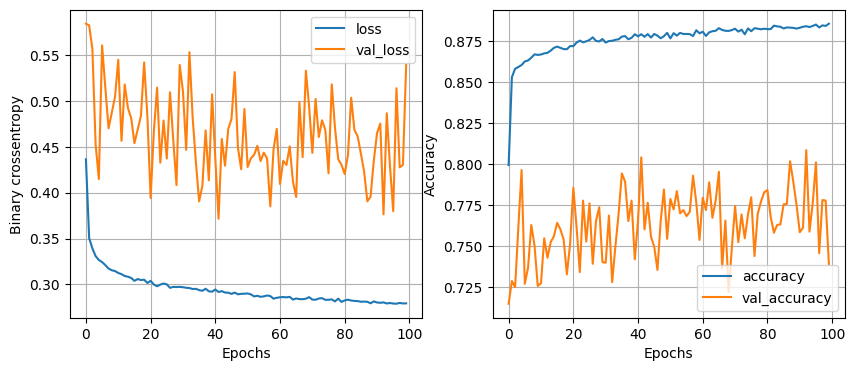

357/357 [==============================] - 1s 2ms/step - loss: 0.2715 - accuracy: 0.8880
16 nodes, dropout 0, learning rate 0.005, batch size 128


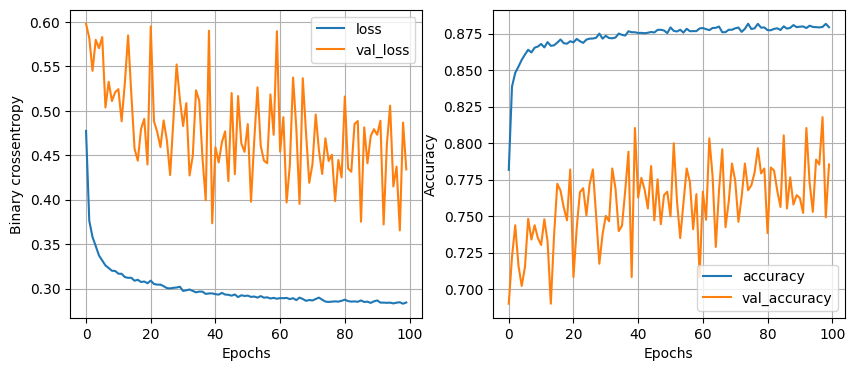

357/357 [==============================] - 1s 2ms/step - loss: 0.2751 - accuracy: 0.8863
16 nodes, dropout 0, learning rate 0.001, batch size 32


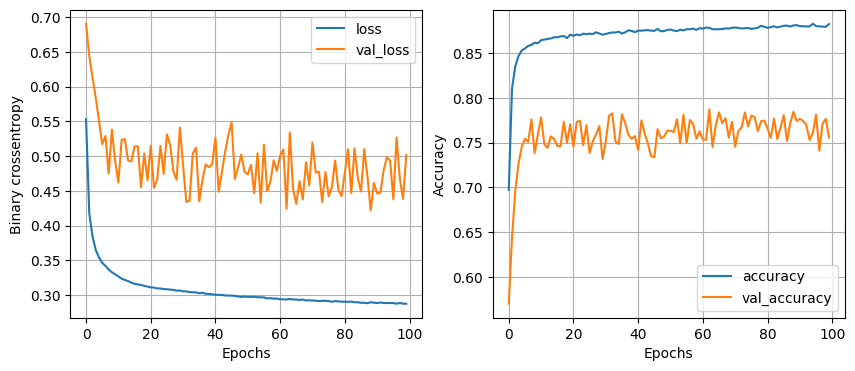

357/357 [==============================] - 1s 2ms/step - loss: 0.2807 - accuracy: 0.8828
16 nodes, dropout 0, learning rate 0.001, batch size 64


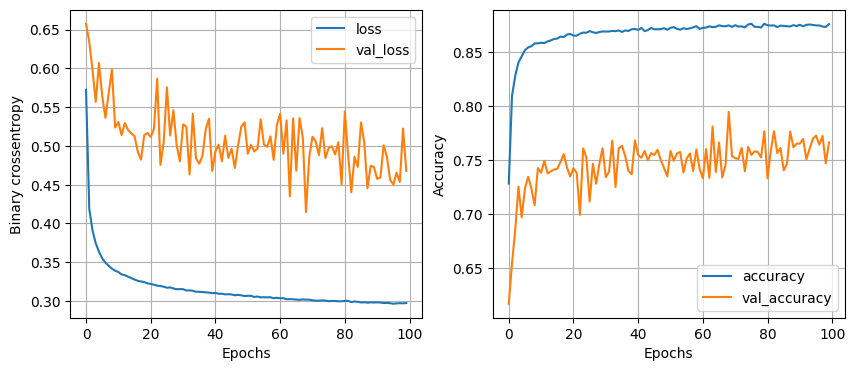

357/357 [==============================] - 1s 2ms/step - loss: 0.2907 - accuracy: 0.8792
16 nodes, dropout 0, learning rate 0.001, batch size 128


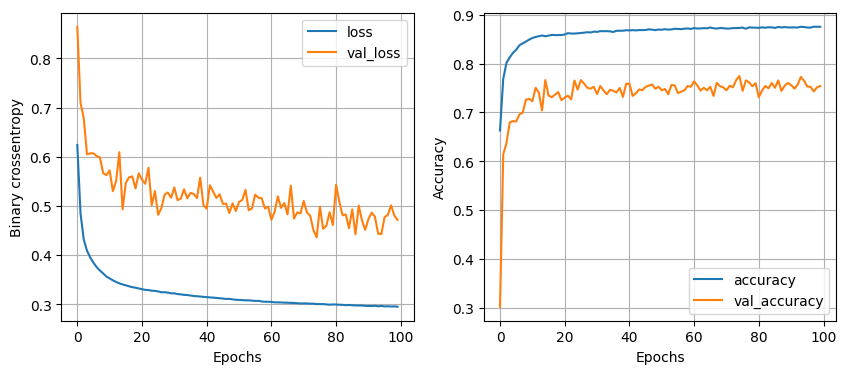

357/357 [==============================] - 1s 2ms/step - loss: 0.2883 - accuracy: 0.8794
16 nodes, dropout 0.2, learning rate 0.01, batch size 32


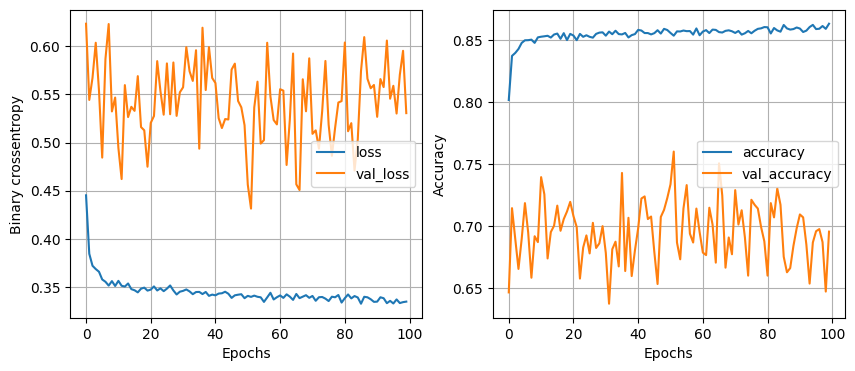

357/357 [==============================] - 1s 2ms/step - loss: 0.3013 - accuracy: 0.8718
16 nodes, dropout 0.2, learning rate 0.01, batch size 64


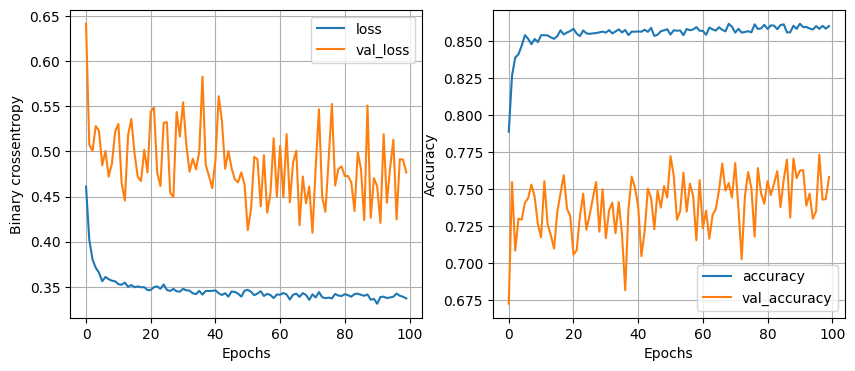

357/357 [==============================] - 1s 2ms/step - loss: 0.3015 - accuracy: 0.8763
16 nodes, dropout 0.2, learning rate 0.01, batch size 128


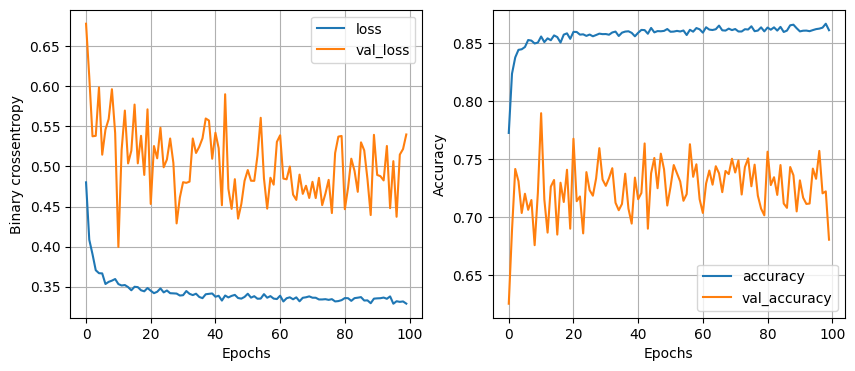

357/357 [==============================] - 1s 2ms/step - loss: 0.3059 - accuracy: 0.8711
16 nodes, dropout 0.2, learning rate 0.005, batch size 32


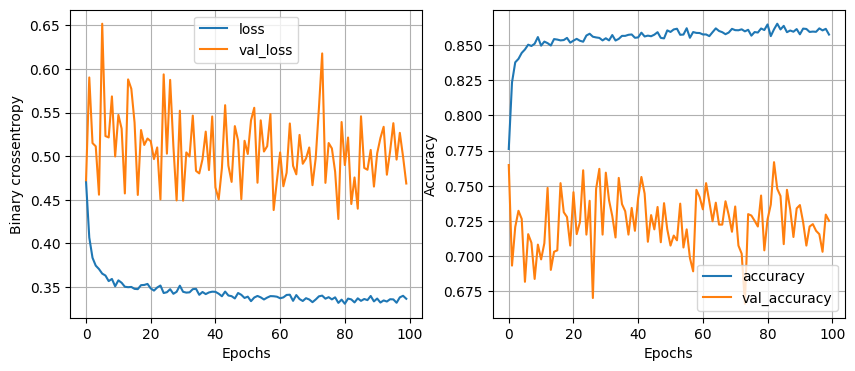

357/357 [==============================] - 1s 2ms/step - loss: 0.3095 - accuracy: 0.8768
16 nodes, dropout 0.2, learning rate 0.005, batch size 64


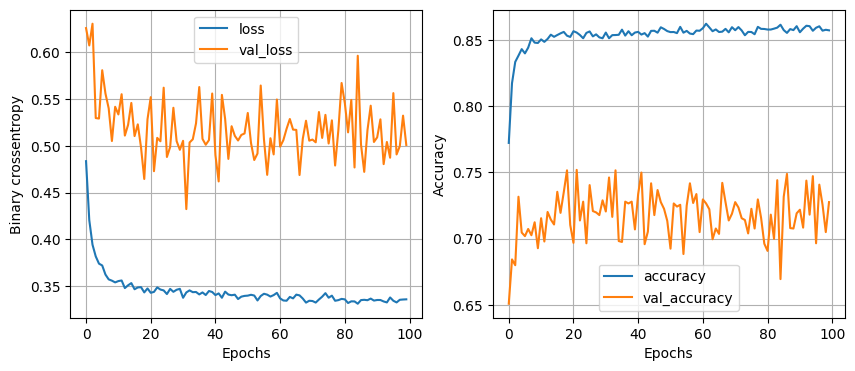

357/357 [==============================] - 1s 4ms/step - loss: 0.2997 - accuracy: 0.8744
16 nodes, dropout 0.2, learning rate 0.005, batch size 128


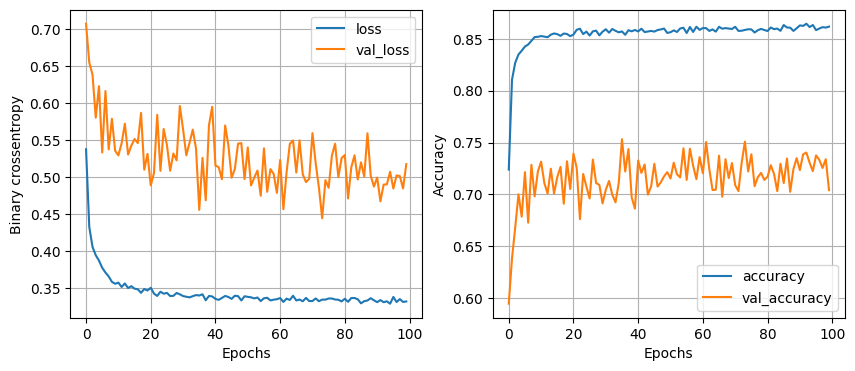

357/357 [==============================] - 1s 2ms/step - loss: 0.3007 - accuracy: 0.8757
16 nodes, dropout 0.2, learning rate 0.001, batch size 32


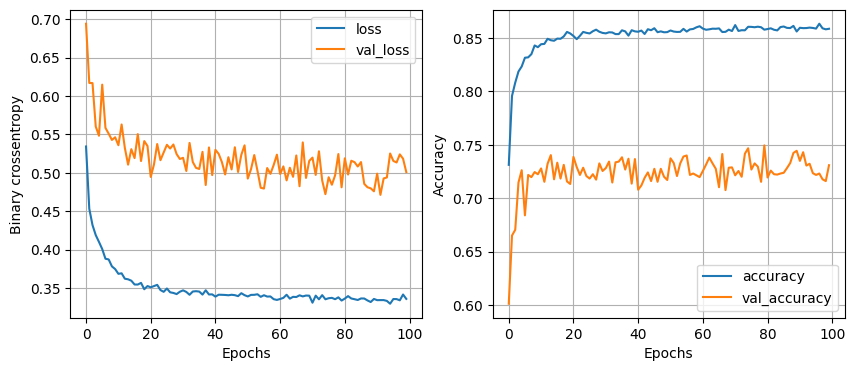

357/357 [==============================] - 1s 3ms/step - loss: 0.3038 - accuracy: 0.8754
16 nodes, dropout 0.2, learning rate 0.001, batch size 64


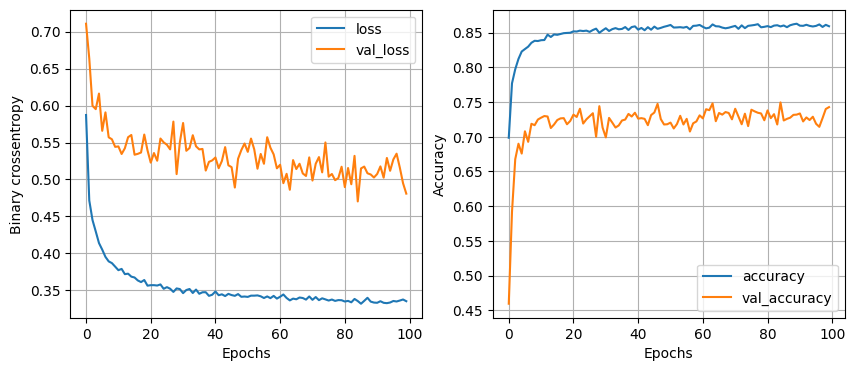

357/357 [==============================] - 1s 2ms/step - loss: 0.3016 - accuracy: 0.8772
16 nodes, dropout 0.2, learning rate 0.001, batch size 128


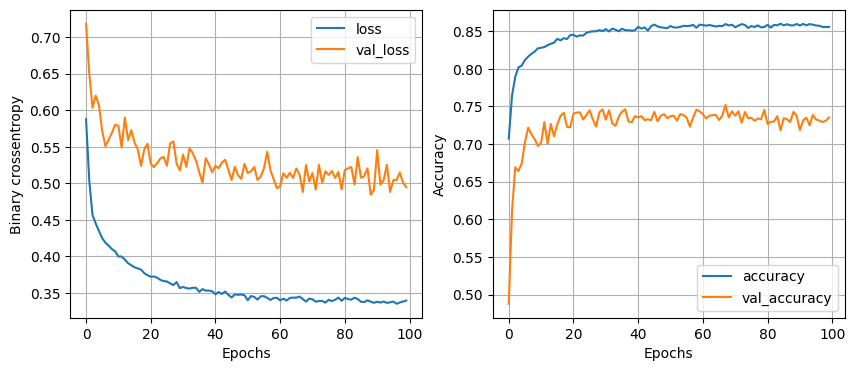

357/357 [==============================] - 1s 2ms/step - loss: 0.3043 - accuracy: 0.8748
32 nodes, dropout 0, learning rate 0.01, batch size 32


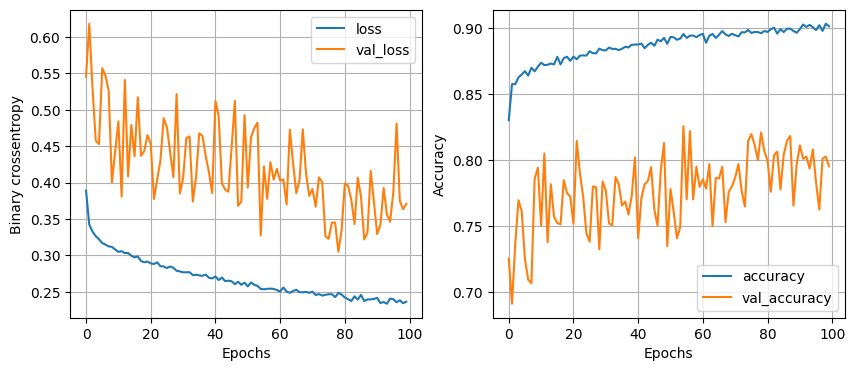

357/357 [==============================] - 1s 2ms/step - loss: 0.2221 - accuracy: 0.9090
32 nodes, dropout 0, learning rate 0.01, batch size 64


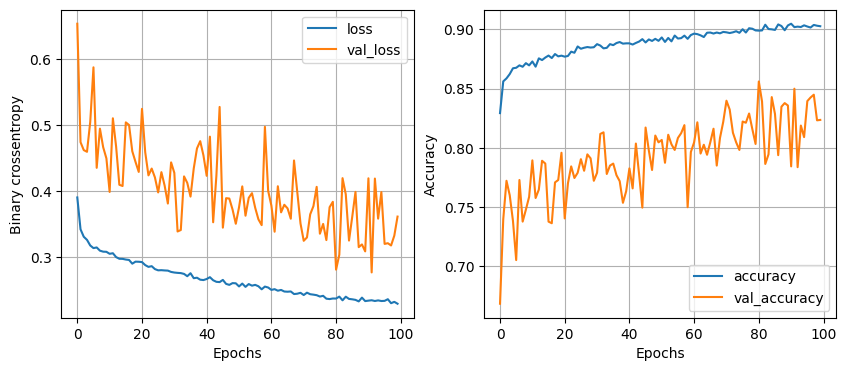

357/357 [==============================] - 1s 2ms/step - loss: 0.2296 - accuracy: 0.9059
32 nodes, dropout 0, learning rate 0.01, batch size 128


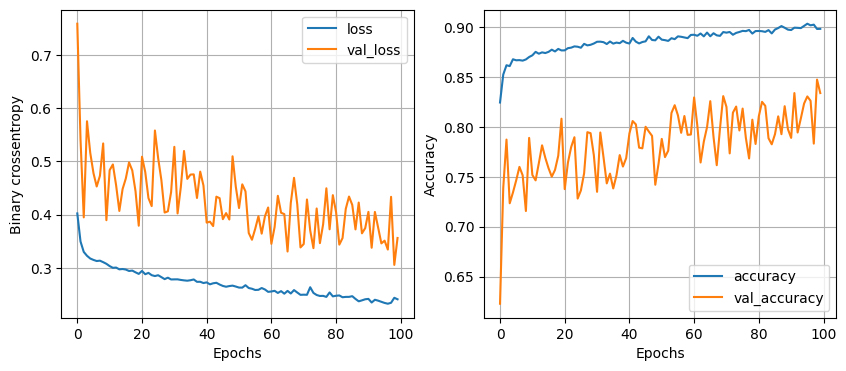

357/357 [==============================] - 1s 2ms/step - loss: 0.2274 - accuracy: 0.9071
32 nodes, dropout 0, learning rate 0.005, batch size 32


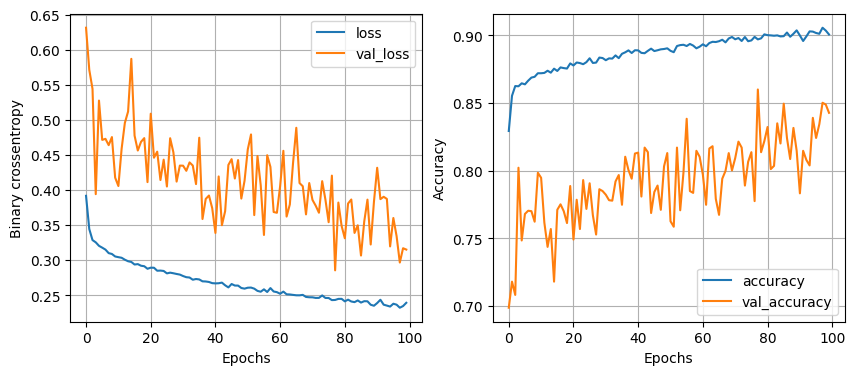

357/357 [==============================] - 1s 2ms/step - loss: 0.2220 - accuracy: 0.9083
32 nodes, dropout 0, learning rate 0.005, batch size 64


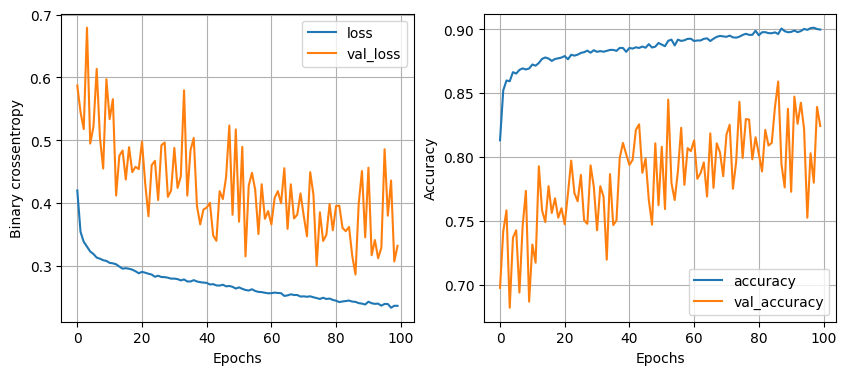

357/357 [==============================] - 2s 5ms/step - loss: 0.2248 - accuracy: 0.9044
32 nodes, dropout 0, learning rate 0.005, batch size 128


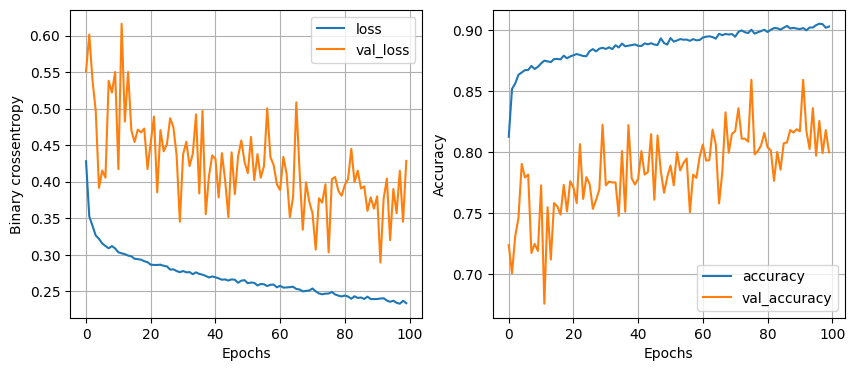

357/357 [==============================] - 1s 2ms/step - loss: 0.2256 - accuracy: 0.9103
32 nodes, dropout 0, learning rate 0.001, batch size 32


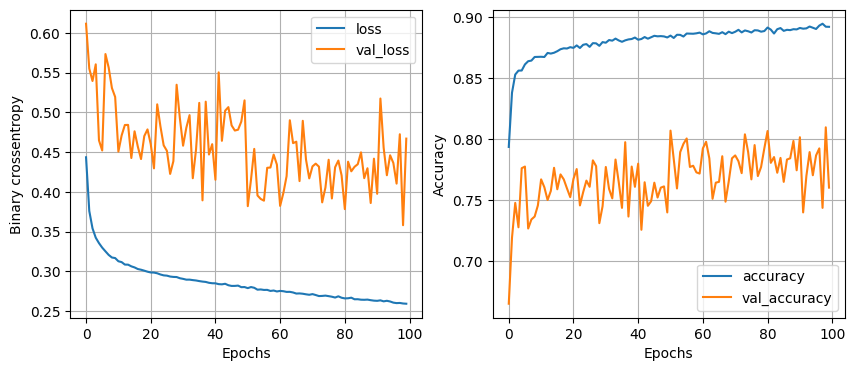

357/357 [==============================] - 1s 2ms/step - loss: 0.2518 - accuracy: 0.8942
32 nodes, dropout 0, learning rate 0.001, batch size 64


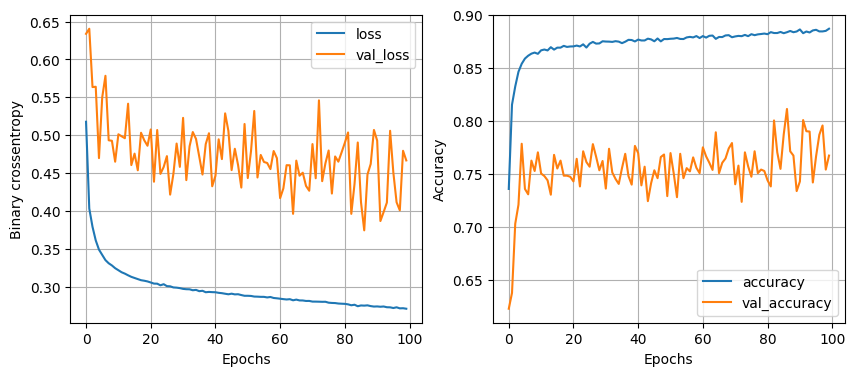

357/357 [==============================] - 1s 2ms/step - loss: 0.2685 - accuracy: 0.8890
32 nodes, dropout 0, learning rate 0.001, batch size 128


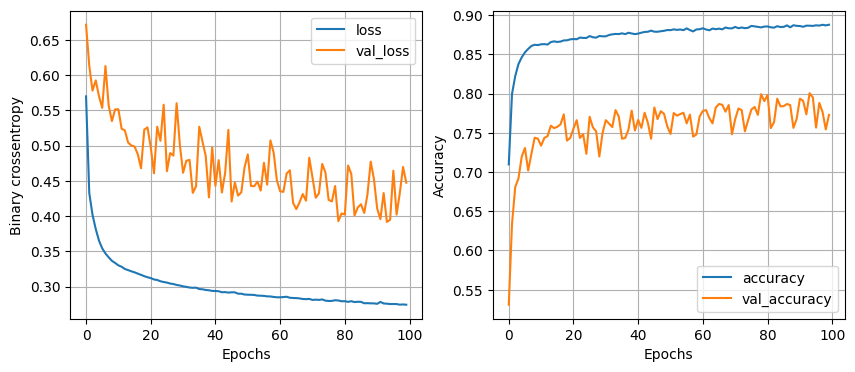

357/357 [==============================] - 1s 2ms/step - loss: 0.2667 - accuracy: 0.8927
32 nodes, dropout 0.2, learning rate 0.01, batch size 32


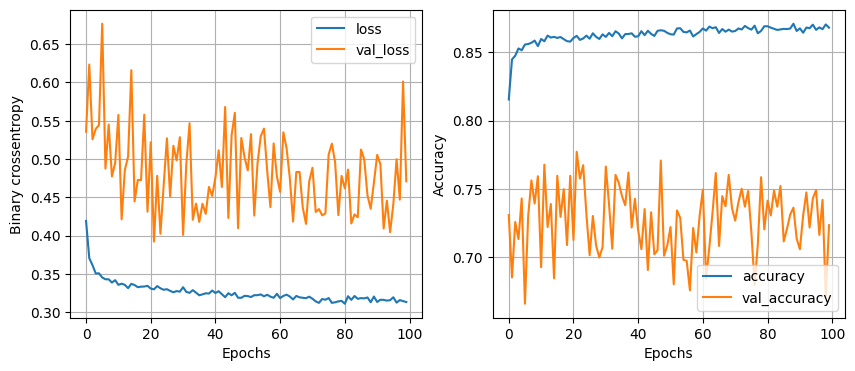

357/357 [==============================] - 4s 11ms/step - loss: 0.2811 - accuracy: 0.8848
32 nodes, dropout 0.2, learning rate 0.01, batch size 64


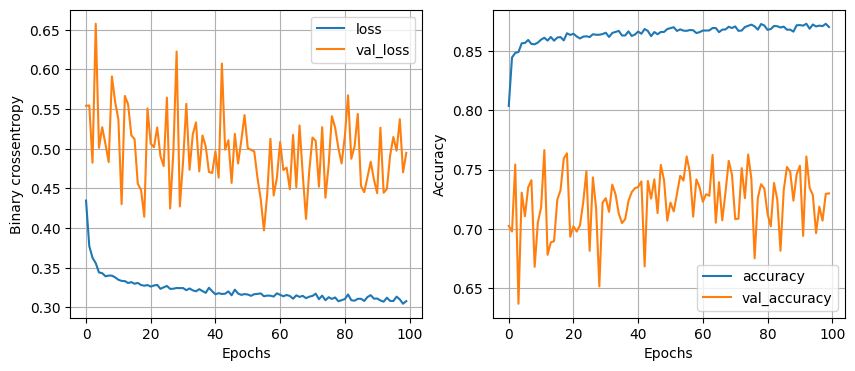

357/357 [==============================] - 1s 2ms/step - loss: 0.2773 - accuracy: 0.8843
32 nodes, dropout 0.2, learning rate 0.01, batch size 128


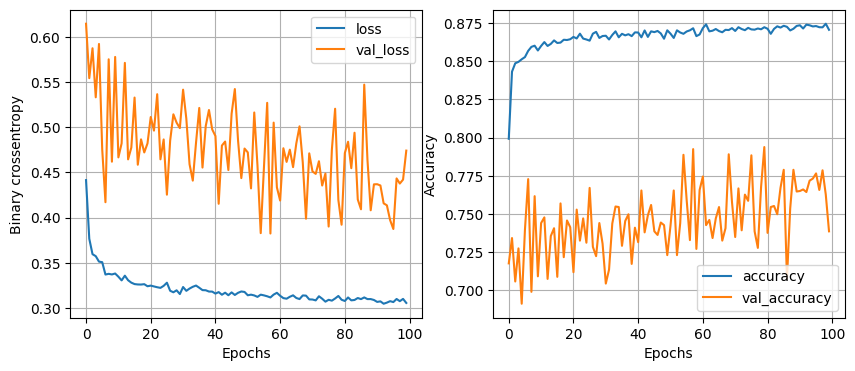

357/357 [==============================] - 1s 2ms/step - loss: 0.2721 - accuracy: 0.8863
32 nodes, dropout 0.2, learning rate 0.005, batch size 32


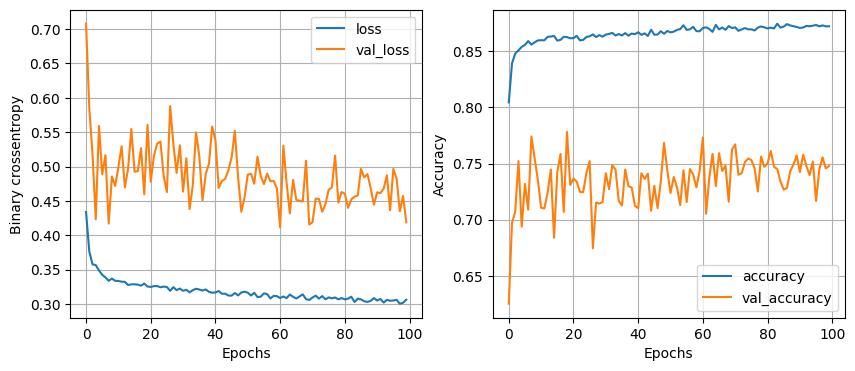

357/357 [==============================] - 1s 2ms/step - loss: 0.2766 - accuracy: 0.8880
32 nodes, dropout 0.2, learning rate 0.005, batch size 64


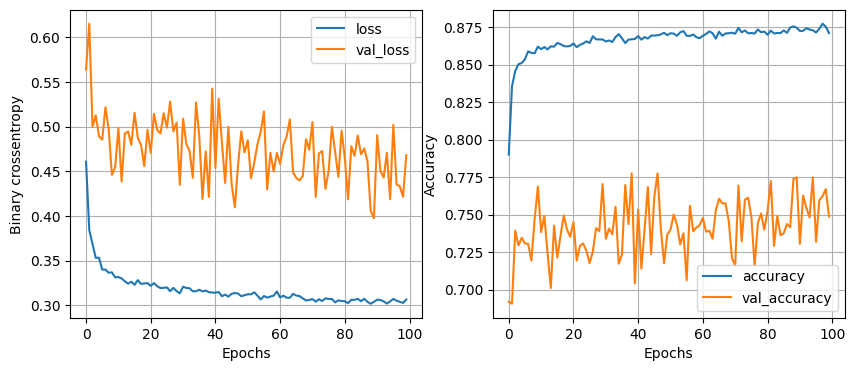

357/357 [==============================] - 1s 2ms/step - loss: 0.2736 - accuracy: 0.8884
32 nodes, dropout 0.2, learning rate 0.005, batch size 128


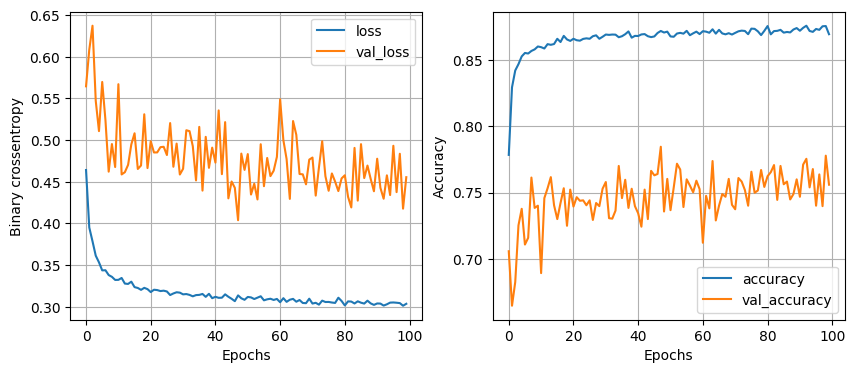

357/357 [==============================] - 1s 2ms/step - loss: 0.2730 - accuracy: 0.8881
32 nodes, dropout 0.2, learning rate 0.001, batch size 32


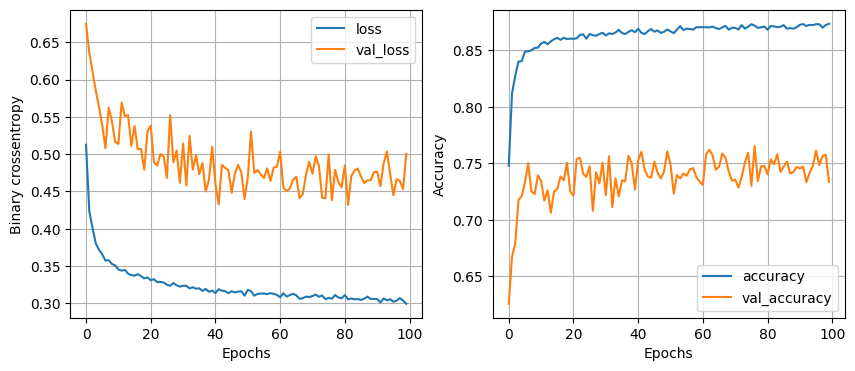

357/357 [==============================] - 1s 2ms/step - loss: 0.2765 - accuracy: 0.8849
32 nodes, dropout 0.2, learning rate 0.001, batch size 64


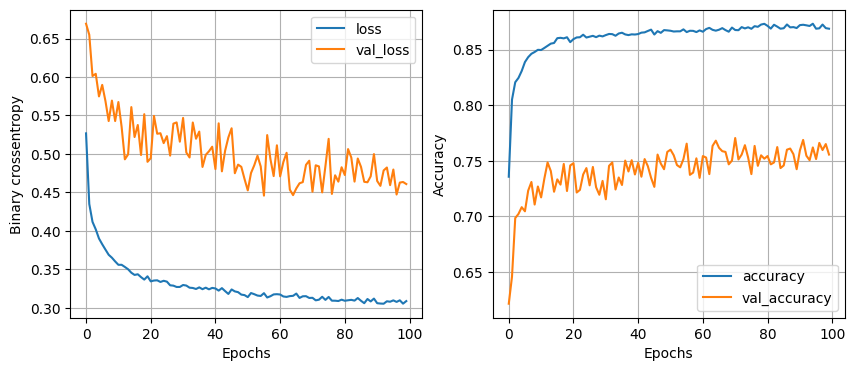

357/357 [==============================] - 1s 2ms/step - loss: 0.2797 - accuracy: 0.8855
32 nodes, dropout 0.2, learning rate 0.001, batch size 128


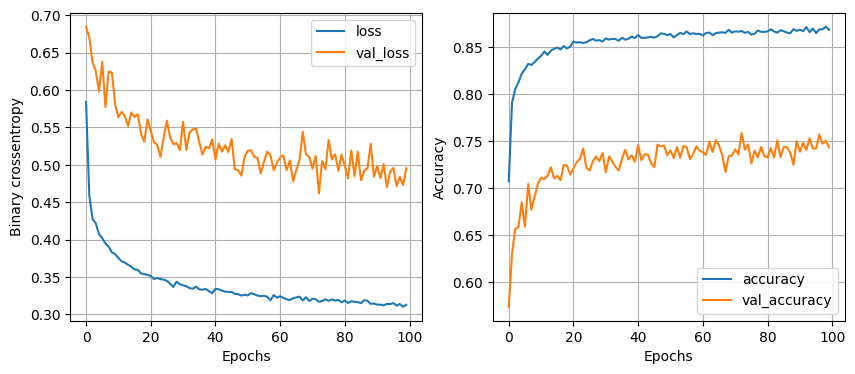

357/357 [==============================] - 1s 2ms/step - loss: 0.2851 - accuracy: 0.8831
64 nodes, dropout 0, learning rate 0.01, batch size 32


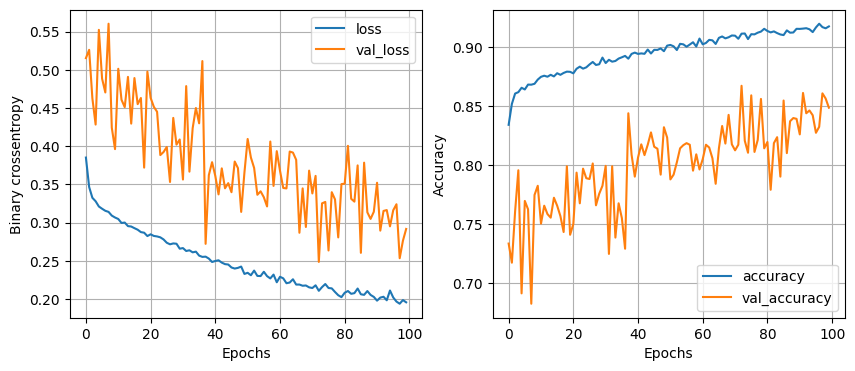

357/357 [==============================] - 1s 2ms/step - loss: 0.1790 - accuracy: 0.9283
64 nodes, dropout 0, learning rate 0.01, batch size 64


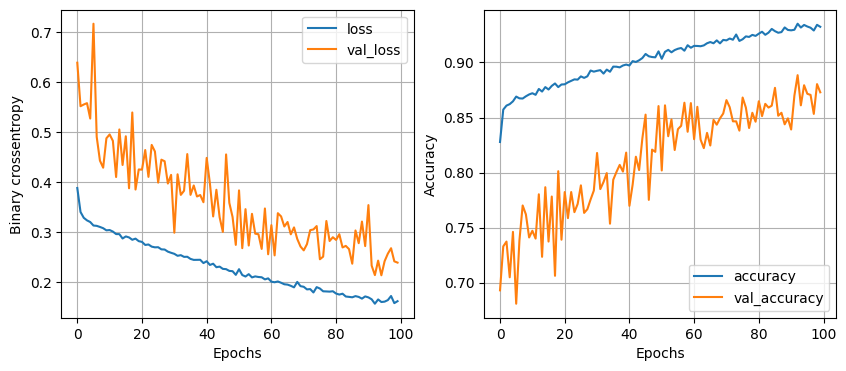

357/357 [==============================] - 1s 2ms/step - loss: 0.1478 - accuracy: 0.9398
64 nodes, dropout 0, learning rate 0.01, batch size 128


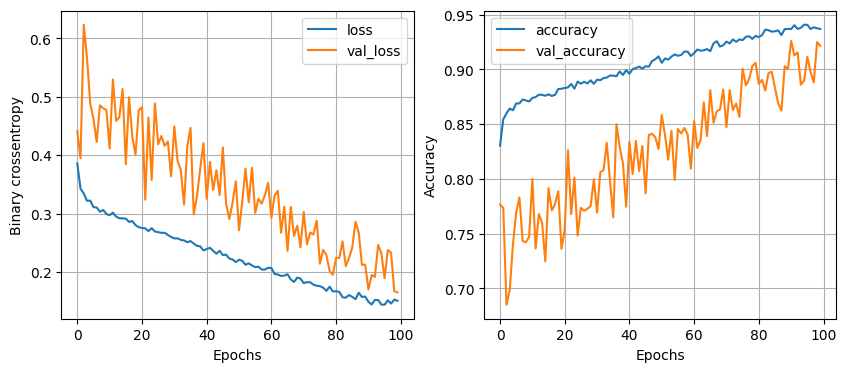

357/357 [==============================] - 1s 2ms/step - loss: 0.1442 - accuracy: 0.9416
64 nodes, dropout 0, learning rate 0.005, batch size 32


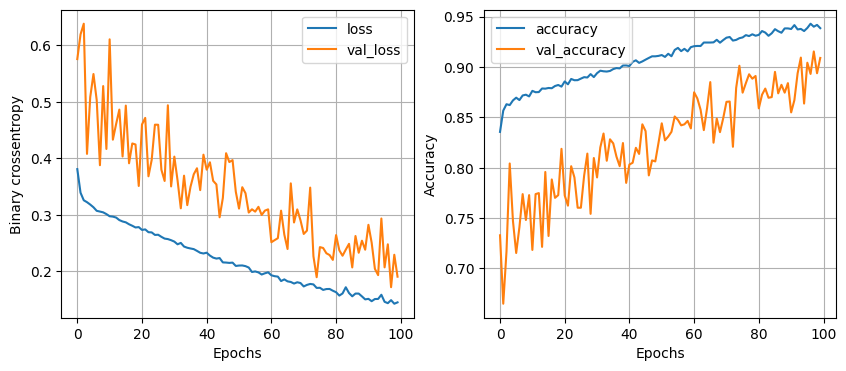

357/357 [==============================] - 1s 2ms/step - loss: 0.1365 - accuracy: 0.9469
64 nodes, dropout 0, learning rate 0.005, batch size 64


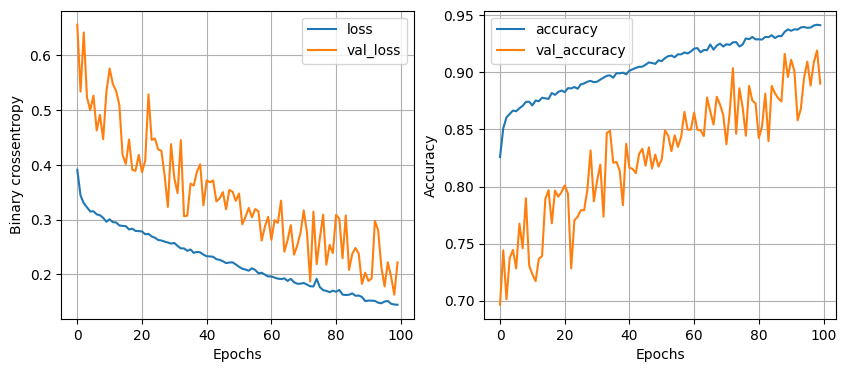

357/357 [==============================] - 1s 2ms/step - loss: 0.1352 - accuracy: 0.9446
64 nodes, dropout 0, learning rate 0.005, batch size 128


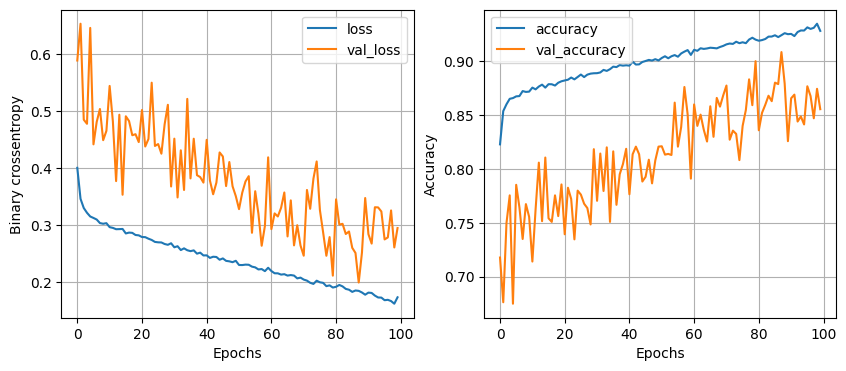

357/357 [==============================] - 1s 2ms/step - loss: 0.1523 - accuracy: 0.9402
64 nodes, dropout 0, learning rate 0.001, batch size 32


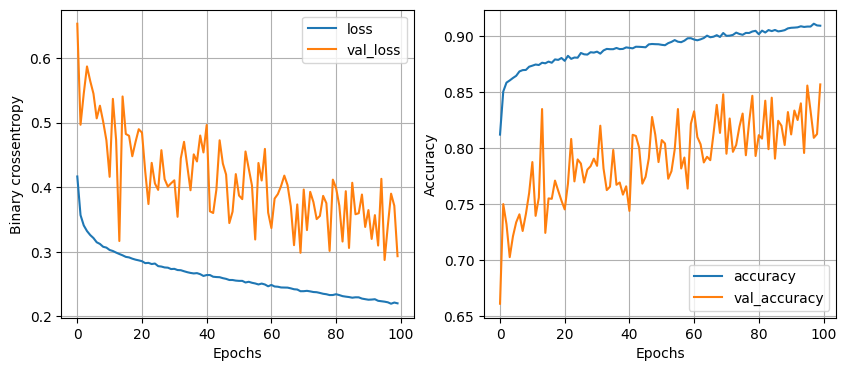

357/357 [==============================] - 1s 2ms/step - loss: 0.2110 - accuracy: 0.9170
64 nodes, dropout 0, learning rate 0.001, batch size 64


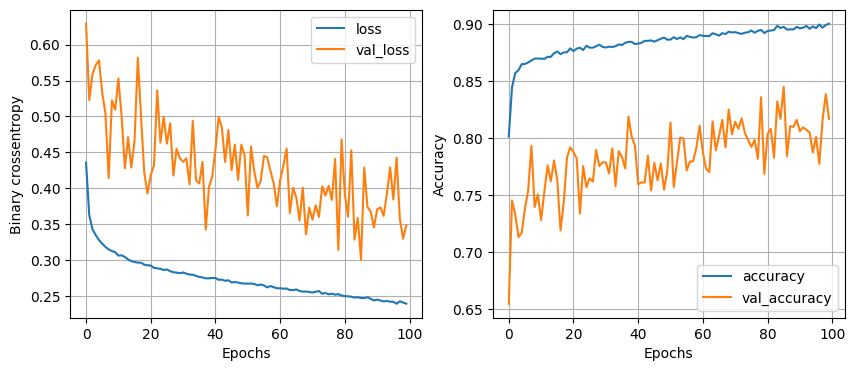

357/357 [==============================] - 1s 2ms/step - loss: 0.2340 - accuracy: 0.9025
64 nodes, dropout 0, learning rate 0.001, batch size 128


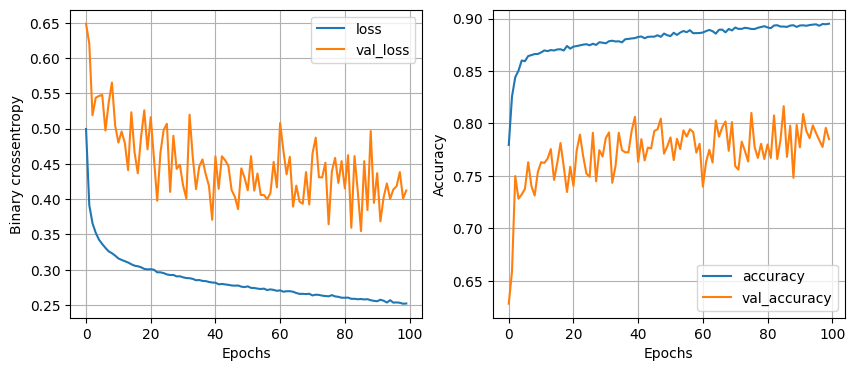

357/357 [==============================] - 1s 2ms/step - loss: 0.2449 - accuracy: 0.8997
64 nodes, dropout 0.2, learning rate 0.01, batch size 32


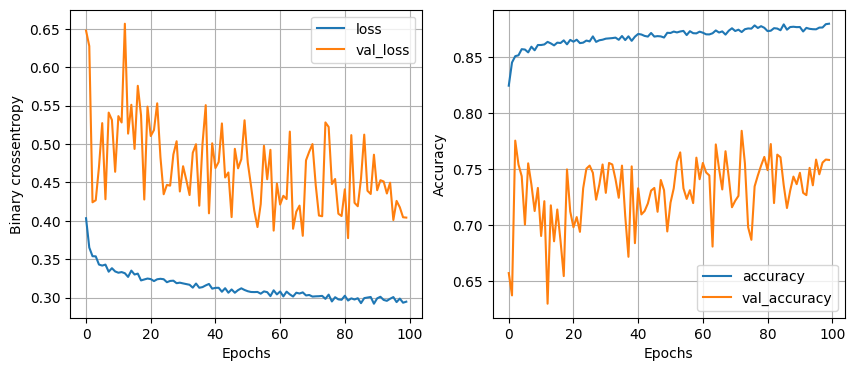

357/357 [==============================] - 1s 2ms/step - loss: 0.2555 - accuracy: 0.8924
64 nodes, dropout 0.2, learning rate 0.01, batch size 64


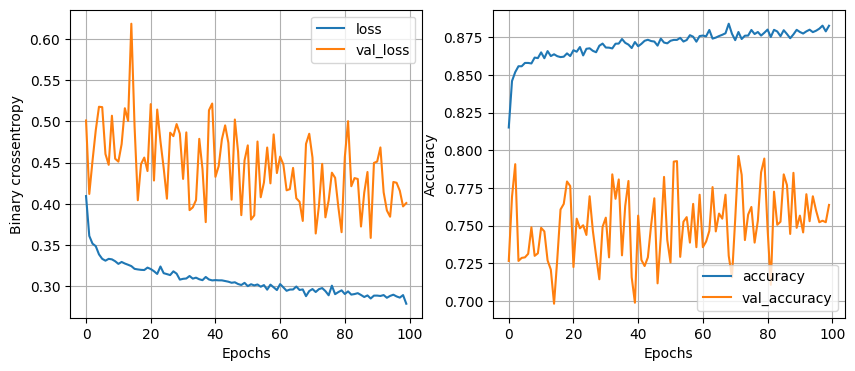

357/357 [==============================] - 1s 2ms/step - loss: 0.2524 - accuracy: 0.8955
64 nodes, dropout 0.2, learning rate 0.01, batch size 128


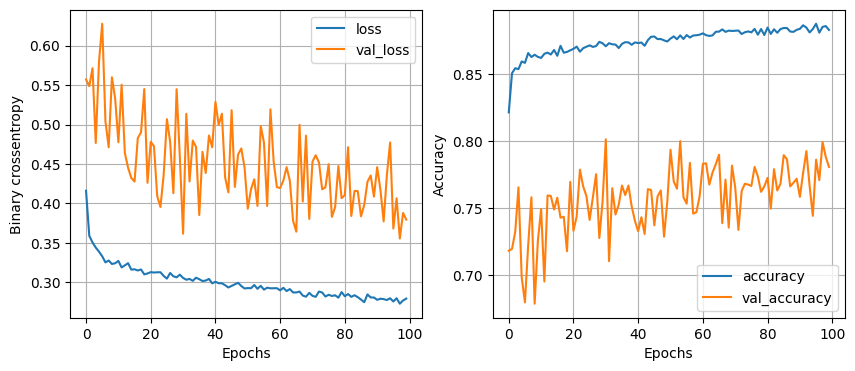

357/357 [==============================] - 1s 2ms/step - loss: 0.2427 - accuracy: 0.9053
64 nodes, dropout 0.2, learning rate 0.005, batch size 32


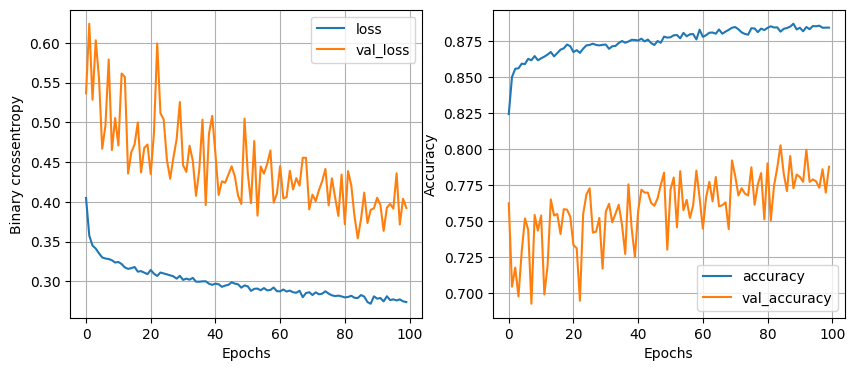

357/357 [==============================] - 1s 2ms/step - loss: 0.2383 - accuracy: 0.9024
64 nodes, dropout 0.2, learning rate 0.005, batch size 64


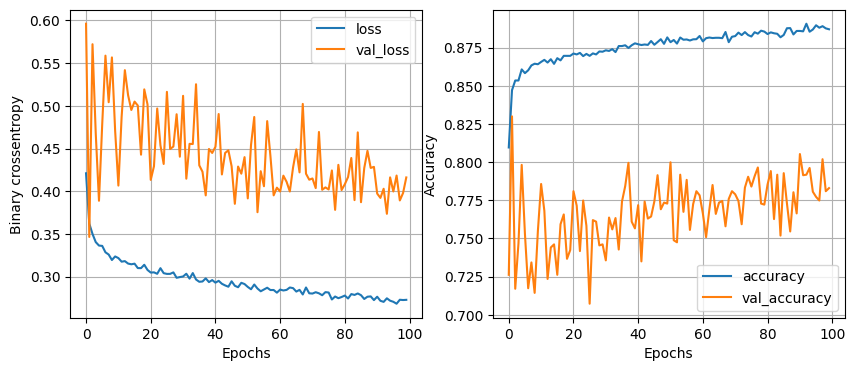

357/357 [==============================] - 1s 2ms/step - loss: 0.2380 - accuracy: 0.9029
64 nodes, dropout 0.2, learning rate 0.005, batch size 128


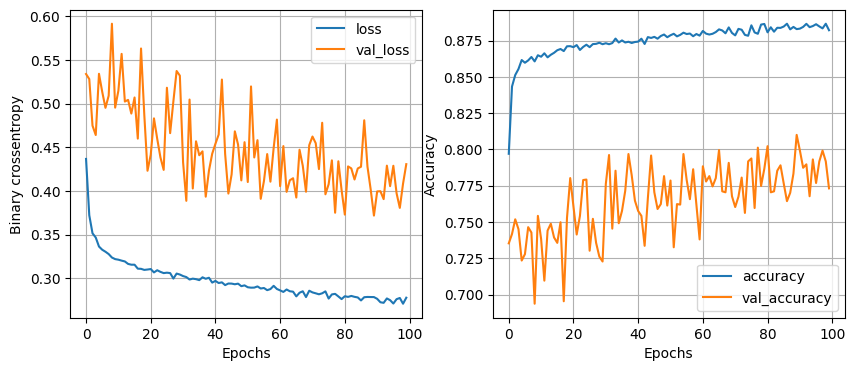

357/357 [==============================] - 1s 2ms/step - loss: 0.2418 - accuracy: 0.9016
64 nodes, dropout 0.2, learning rate 0.001, batch size 32


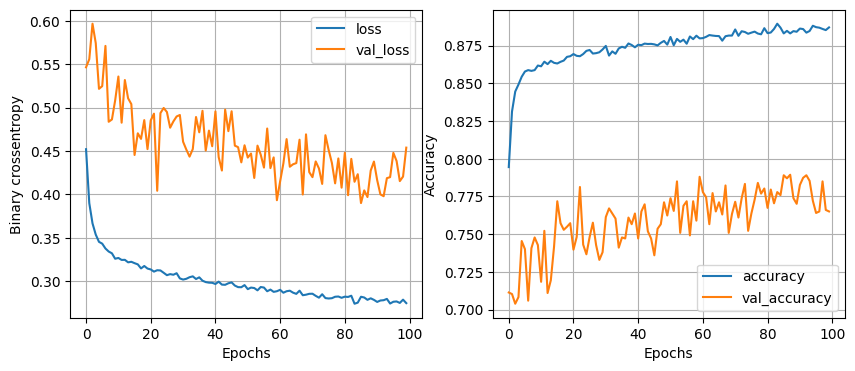

357/357 [==============================] - 1s 2ms/step - loss: 0.2459 - accuracy: 0.9006
64 nodes, dropout 0.2, learning rate 0.001, batch size 64


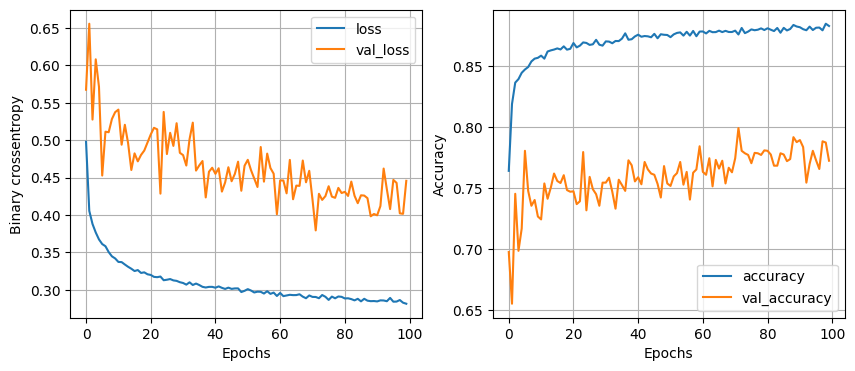

357/357 [==============================] - 1s 2ms/step - loss: 0.2558 - accuracy: 0.8955
64 nodes, dropout 0.2, learning rate 0.001, batch size 128


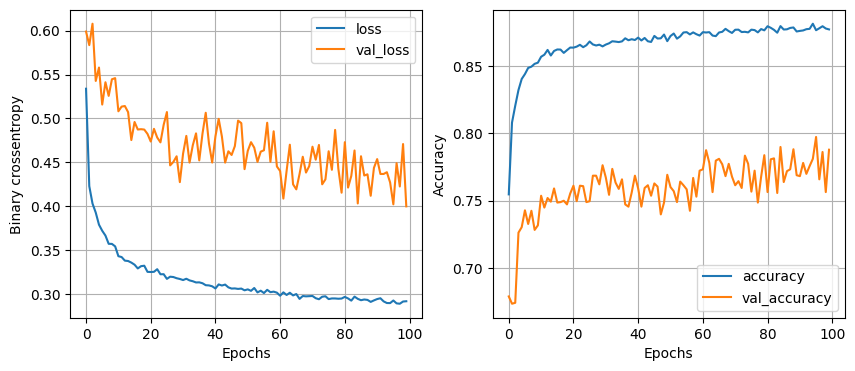

357/357 [==============================] - 1s 2ms/step - loss: 0.2689 - accuracy: 0.8906


In [ ]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 100

#trying out different parameters
for num_nodes in [16, 32, 64]:
  for dropout_prob in [0, 0.2]:
    for lr in [0.01, 0.005, 0.001]:
      for batch_size in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout {dropout_prob}, learning rate {lr}, batch size {batch_size}")
        nn_model, history = train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_loss(history)
        val_loss = nn_model.evaluate(x_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = nn_model

Do want to see val_loss decreasing and val_accuracy increasing - to be expected tha val_loss and val_accuracy would be worse than train loss or accuracy since train data is what it's being trained on\
Can see best performance

In [ ]:
y_pred = least_loss_model.predict(x_test)
#since have sigmoid output function, will give values either close to 0 or 1, so turning them into integers to get 0 or 1
#also reshaping as a column so 1D
y_pred =(y_pred > 0.5).astype(int).reshape(-1,)

357/357 [==============================] - 1s 1ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      4017
           1       0.94      0.97      0.96      7395

    accuracy                           0.94     11412
   macro avg       0.94      0.93      0.94     11412
weighted avg       0.94      0.94      0.94     11412

